# Imports / Config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
from datetime import datetime
from functools import reduce
from operator import itemgetter
import os
import pickle
import pprint
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from content_corpus import ContentCorpus

pp = pprint.PrettyPrinter()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Load recent content corpus

In [3]:
%%time
recent_content_corpus = ContentCorpus(verbose=True)

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 48.9 µs


In [4]:
%%time
recent_content_corpus.load_recent_content(df=pd.read_csv('recent_content_corpus.csv', index_col=0),
                                          days_of_recent_content=2)
recent_content_corpus.df['meta_keywords'] = recent_content_corpus.df['meta_keywords'].apply(lambda x: x if type(x)== type('this') else '')
# recent_content_corpus.load_recent_content(days_of_recent_content=2)

CPU times: user 1.74 s, sys: 447 ms, total: 2.18 s
Wall time: 2.42 s


In [5]:
recent_content_corpus.df.to_csv('recent_content_corpus.csv')

In [6]:
%%time
recent_content_corpus.vectorize_content()

CPU times: user 58min 16s, sys: 8min 49s, total: 1h 7min 5s
Wall time: 17min 56s


In [7]:
%%time
recent_content_corpus.categorize_content()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



 svm classifier performance
 accuracy:   0.789
 classification report: 
                                precision    recall  f1-score   support

          Entertainment & Arts       0.75      0.91      0.82        45
            Finance & Business       0.78      0.84      0.81        82
                Gear & Gadgets       1.00      0.29      0.44         7
            Lifestyle & Health       0.63      0.50      0.56        24
  Politics, Policy & Economics       0.78      0.91      0.84        56
Technology, Science & Medicine       0.83      0.74      0.78        66
                 Travel & Food       0.00      0.00      0.00         6
                   U.S. Sports       1.00      0.83      0.91        18
                  World Sports       0.80      1.00      0.89         4

                   avg / total       0.78      0.79      0.78       308

 confusion matrix: 
[[41  0  0  3  1  0  0  0  0]
 [ 0 69  0  0  9  4  0  0  0]
 [ 0  0  2  1  0  4  0  0  0]
 [10  1  0 12  0  0  0

In [8]:
a = recent_content_corpus.texts_tfidf_matrix
print((a.data.nbytes + a.indptr.nbytes + a.indices.nbytes)/1e6)

83.86352


# Determine parts of speech for texts vocab

In [9]:
import spacy
from spacy.tokens import Doc

nlp = spacy.load('en_core_web_lg')

class WhitespaceTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(' ')
        # All tokens 'own' a subsequent space character in this tokenizer
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [10]:
def vocab_to_pos(vocab):
    n = len(vocab)
    batch_size = 10000
    pos = []
    
    for start_idx in np.arange(0, n, batch_size):
        end_idx = min(start_idx + batch_size, n)
        vocab_str = ' '.join(vocab[start_idx:end_idx])
        pos += [spacy_token.pos_ for spacy_token in nlp(vocab_str)]
        
    return pos

In [11]:
%%time
texts_tfidf_pos = vocab_to_pos(recent_content_corpus.texts_tfidf_vocab)

CPU times: user 19.6 s, sys: 4.03 s, total: 23.7 s
Wall time: 7.12 s


In [12]:
texts_tfidf_pos = np.array(texts_tfidf_pos)

texts_nouns_idxs = np.where([pos in ['NOUN', 'PROPN'] for pos in texts_tfidf_pos])[0]
texts_nouns_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[:, texts_nouns_idxs]

texts_adjs_idxs = np.where(texts_tfidf_pos == 'ADJ')[0]
texts_adjs_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[:, texts_adjs_idxs]

# Create dense vectors

In [13]:
%%time
titles_dense_matrix = np.array(
    [nlp(title).vector for title in recent_content_corpus.df['title']]
)

CPU times: user 23min 41s, sys: 3min 16s, total: 26min 57s
Wall time: 7min 8s


In [14]:
import configs

In [15]:
%%time
texts_dense_matrix = np.array(
    [nlp(' '.join(text.split(' ')[:configs.STORY_TEXT_WORDS_TO_CONSIDER])).vector
     if len(text.split(' ')) > 0 else np.zeros(300)
     for text in recent_content_corpus.df['text']]
)

CPU times: user 44min 40s, sys: 5min 31s, total: 50min 11s
Wall time: 13min 1s


# Make topic cluster classifier

## Sample some article pairs

In [ ]:
def sample_article_pairs(df, n, extra_fields=None):
    fields = ['_id']
    if extra_fields:
        fields += extra_fields
    
    first_articles = df[fields].sample(n, replace=True).reset_index()
    first_articles.columns = [colname + '_0' for colname in first_articles.columns]
    second_articles = df[fields].sample(n, replace=True).reset_index()
    second_articles.columns = [colname + '_1' for colname in second_articles.columns]
    
    article_pairs = pd.concat([first_articles, second_articles], axis=1)
    
    return article_pairs
    

In [ ]:
subset = recent_content_corpus.df.copy()

In [ ]:
topic_cluster_training_article_pairs = sample_article_pairs(subset, 250000, extra_fields=['title'])

In [ ]:
topic_cluster_training_article_pairs.head()

## Calculate metrics for sampled pairs

In [16]:
from scipy.spatial.distance import cosine

In [17]:
def selected_article_pairs_metrics(df):
    title_dists = np.zeros(len(df))
    text_dists = np.zeros(len(df))
    text_nouns_dists = np.zeros(len(df))
    text_adjs_dists = np.zeros(len(df))
    title_dense_dists = np.zeros(len(df))
    text_dense_dists = np.zeros(len(df))

    for idx, row in df.iterrows():
        article_1_idx = row['index_0']
        article_2_idx = row['index_1']

        title_dist, text_dist, text_nouns_dist, text_adjs_dist = (
            article_pair_metrics(article_1_idx, article_2_idx)
        )
        
        title_dense_dist = np.round(cosine(
            titles_dense_matrix[article_1_idx],
            titles_dense_matrix[article_2_idx]
        ), 4)
        
        text_dense_dist = np.round(cosine(
            texts_dense_matrix[article_1_idx],
            texts_dense_matrix[article_2_idx]
        ), 4)

        title_dists[idx] = title_dist
        text_dists[idx] = text_dist
        text_nouns_dists[idx] = text_nouns_dist
        text_adjs_dists[idx] = text_adjs_dist
        title_dense_dists[idx] = title_dense_dist
        text_dense_dists[idx] = text_dense_dist

    df['title_dist'] = title_dists
    df['text_dist'] = text_dists
    df['text_nouns_dist'] = text_nouns_dists
    df['text_adjs_dist'] = text_adjs_dists
    df['title_dense_dist'] = title_dense_dists
    df['text_dense_dist'] = text_dense_dists

    return df


def article_pair_metrics(article_1_idx, article_2_idx):
    title_dist = cosine_dist(
        recent_content_corpus.titles_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_dist = cosine_dist(
        recent_content_corpus.texts_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_nouns_dist = cosine_dist(
        texts_nouns_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_adjs_dist = cosine_dist(
        texts_adjs_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    return title_dist, text_dist, text_nouns_dist, text_adjs_dist


def cosine_dist(doc_term_matrix, doc_1_idx, doc_2_idx):
    doc_1_vector = doc_term_matrix[doc_1_idx].toarray()
    doc_2_vector = doc_term_matrix[doc_2_idx].toarray()    
    cosine_dist = np.round(cosine(doc_1_vector, doc_2_vector), 4)
    return cosine_dist

In [ ]:
%%time
topic_cluster_training_article_pairs = selected_article_pairs_metrics(topic_cluster_training_article_pairs)

In [ ]:
topic_cluster_training_article_pairs.head()

In [ ]:
topic_cluster_training_article_pairs[:50000].to_csv('topic_cluster_training_article_pairs_250k.csv')

In [ ]:
topic_cluster_training_article_pairs[50000:100000].to_csv('topic_cluster_training_article_pairs_250k_2.csv')

In [ ]:
topic_cluster_training_article_pairs[100000:150000].to_csv('topic_cluster_training_article_pairs_250k_3.csv')

In [ ]:
topic_cluster_training_article_pairs[150000:200000].to_csv('topic_cluster_training_article_pairs_250k_4.csv')

In [ ]:
topic_cluster_training_article_pairs[200000:250000].to_csv('topic_cluster_training_article_pairs_250k_5.csv')

## Label the sampled pairs

[ done manually ]

## Ingest the labeled pairs

In [18]:
labeled_tc_pairs = pd.read_csv('../training_data/labeled_topic_cluster_training_article_pairs_250k_1.csv', index_col=0)

In [19]:
for i in range(2, 5):
    filestr = ('../training_data/labeled_topic_cluster_training_article_pairs_250k_%s.csv' % (i))
    labeled_tc_pairs = labeled_tc_pairs.append(pd.read_csv(filestr, index_col=0))

In [20]:
%%time
# always use the freshest metrics
labeled_tc_pairs = selected_article_pairs_metrics(labeled_tc_pairs) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


CPU times: user 6min 6s, sys: 8.9 s, total: 6min 15s
Wall time: 6min 25s


In [21]:
labeled_tc_pairs.shape

(200000, 13)

## Fit classifier

In [22]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
features = ['title_dist', 'text_dist', 'text_nouns_dist', 'text_adjs_dist', 
            'title_dense_dist', 'text_dense_dist']

In [24]:
for feature in features:
    labeled_tc_pairs[feature] = (
        labeled_tc_pairs[feature].apply(lambda x: 1 if np.isnan(x) else x)
    )


Mean precision: 0.8905538378704789


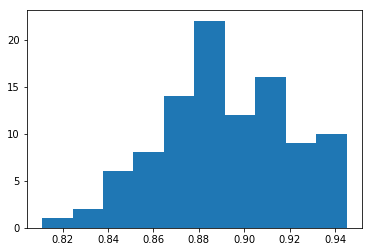

Mean recall: 0.41528388311142833


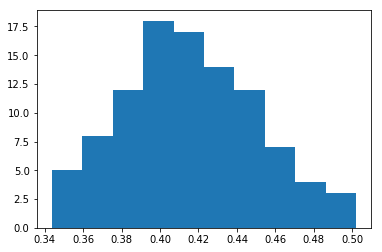

In [25]:
sgds = []
precisions = []
recalls = []
for i in tqdm_notebook(np.arange(100)):
    X = labeled_tc_pairs[features]
    y = labeled_tc_pairs['same_topic_cluster']

    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, test_size=0.5)
    )

    sgd = SGDClassifier(
        loss='modified_huber',
        max_iter=100,
        n_jobs=2,
        learning_rate='optimal',
        penalty='l2',
        alpha=0.0001
    )
    sgd.fit(X_train, y_train)

    pred = sgd.predict(X_test)
    
    sgds += [sgd]
    precisions += [metrics.precision_score(y_test, pred)]
    recalls += [metrics.recall_score(y_test, pred)]
    
print('Mean precision: %s' % str(np.mean(precisions)))
plt.hist(precisions)
plt.show()
print('Mean recall: %s' % str(np.mean(recalls)))
plt.hist(recalls)
plt.show()

In [26]:
precisions[-10:]

[0.8854961832061069,
 0.8818181818181818,
 0.9230769230769231,
 0.9038461538461539,
 0.8611111111111112,
 0.9193548387096774,
 0.8898305084745762,
 0.8773584905660378,
 0.91,
 0.9411764705882353]

In [27]:
recalls[-10:]

[0.48945147679324896,
 0.4217391304347826,
 0.375,
 0.37751004016064255,
 0.39914163090128757,
 0.456,
 0.42168674698795183,
 0.4025974025974026,
 0.3699186991869919,
 0.37065637065637064]

In [ ]:
# tcc = sgds[-1]
# with open('topic_cluster_classifier.pkl', 'wb') as output:
#     pickle.dump(tcc, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('topic_cluster_classifier.pkl', 'rb') as input:
    tcc = pickle.load(input)

In [ ]:
tcc.coef_

In [ ]:
labeled_tc_pairs['same_topic_cluster_predicted'] = (
    tcc.predict(X)
)
labeled_tc_pairs['same_topic_cluster_probability'] = (
    tcc.predict_proba(X)[:, 1]
)

In [ ]:
for idx, row in labeled_tc_pairs[
    ((labeled_tc_pairs.same_topic_cluster == 0)
     & (labeled_tc_pairs.same_topic_cluster_predicted == 1))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

In [ ]:
for idx, row in labeled_tc_pairs[
    ((labeled_tc_pairs.same_topic_cluster == 1)
     & (labeled_tc_pairs.same_topic_cluster_predicted == 0))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

# Supervised topic clustering

## Generate same_topic_cluster_probs graph

In [ ]:
from scipy.sparse import csr_matrix, lil_matrix, dok_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.sparsetools import connected_components

from clustering import agglomeratively_cluster_dist_matrix, gen_clusters

In [ ]:
def get_same_topic_cluster_probs(subset, pairs_dists_max_memory_use_mb=500):
    n_articles = len(subset)
    subset_indices = subset.index.values
    
    same_topic_cluster_probs = lil_matrix((n_articles, n_articles))
    num_dist_matrices = 6
    per_dist_matrix_max_memory = pairs_dists_max_memory_use_mb / num_dist_matrices / 2
    cols_batch = int(min(n_articles, per_dist_matrix_max_memory/8e-6))
    rows_batch = int(min(n_articles, per_dist_matrix_max_memory/(cols_batch * 8e-6)))

    # slice first articles
    for start_row in np.arange(0, n_articles, rows_batch):
        end_row = min(start_row+rows_batch, n_articles)

        # get first articles' vectors
        first_article_indices = subset_indices[start_row:end_row]
        first_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[first_article_indices]
        first_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[first_article_indices]
        first_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[first_article_indices]
        first_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[first_article_indices]
        first_titles_dense_matrix = titles_dense_matrix[first_article_indices]
        first_texts_dense_matrix = texts_dense_matrix[first_article_indices]

        # slice second articles
        for start_col in np.arange(start_row, n_articles, cols_batch):
            end_col = min(start_col+cols_batch, n_articles)

            # get second articles' vectors
            second_article_indices = subset_indices[start_col:end_col]    
            second_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[second_article_indices]
            second_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[second_article_indices]
            second_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[second_article_indices]
            second_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[second_article_indices]
            second_titles_dense_matrix = titles_dense_matrix[second_article_indices]
            second_texts_dense_matrix = texts_dense_matrix[second_article_indices]

            # create article pairs distance matrices
            titles_dists = 1-cosine_similarity(first_titles_tfidf_matrix, second_titles_tfidf_matrix)
            texts_dists = 1-cosine_similarity(first_texts_tfidf_matrix, second_texts_tfidf_matrix)
            nouns_dists = 1-cosine_similarity(first_nouns_tfidf_matrix, second_nouns_tfidf_matrix)
            adjs_dists = 1-cosine_similarity(first_adjs_tfidf_matrix, second_adjs_tfidf_matrix)
            titles_dense_dists = 1-cosine_similarity(first_titles_dense_matrix, second_titles_dense_matrix)
            texts_dense_dists = 1-cosine_similarity(first_texts_dense_matrix, second_texts_dense_matrix)
            
            # conserve memory
            del second_article_indices, second_titles_tfidf_matrix, second_texts_tfidf_matrix,\
                second_nouns_tfidf_matrix, second_adjs_tfidf_matrix, second_titles_dense_matrix,\
                second_texts_dense_matrix
            
            # combine article pairs distances
            pairs_metrics = pd.merge(
                subset[['const', 'n']][start_row:end_row], 
                subset[['const', 'n']][start_col:end_col], 
                on='const'
            )
            pairs_metrics['title_dist'] = titles_dists.reshape(-1)
            pairs_metrics['text_dist'] = texts_dists.reshape(-1)
            pairs_metrics['text_nouns_dist'] = nouns_dists.reshape(-1)
            pairs_metrics['text_adjs_dist'] = adjs_dists.reshape(-1)
            pairs_metrics['title_dense_dist'] = titles_dense_dists.reshape(-1)
            pairs_metrics['text_dense_dist'] = texts_dense_dists.reshape(-1)
            
            # conserve memory
            del titles_dists, texts_dists, nouns_dists, adjs_dists, titles_dense_dists,\
                texts_dense_dists

            # estimate p(same_cluster)
            pairs_metrics['same_topic_cluster_probability'] = (
                tcc.predict_proba(pairs_metrics[features])[:, 1]
            )
            
            pairs_metrics = pairs_metrics[
                pairs_metrics['same_topic_cluster_probability'] > 0
            ]
            
            for x, y, p in zip(pairs_metrics['n_x'],
                               pairs_metrics['n_y'],
                               pairs_metrics['same_topic_cluster_probability']):
                same_topic_cluster_probs[x, y] = same_topic_cluster_probs[y, x] = p
    
    return same_topic_cluster_probs

## Cluster same_topic_cluster_probs graph

In [ ]:
subset = recent_content_corpus.df[
    ((recent_content_corpus.df.region_categorization_predicted == 'U.S. & Canada')
     & (recent_content_corpus.df.region_categorization_probability > 0.5)
     & (recent_content_corpus.df.topic_categorization_predicted == 'Politics, Policy & Economics')
     & (recent_content_corpus.df.topic_categorization_probability > 0.5))
]
subset.loc[:, 'const'] = np.zeros(len(subset))
subset.loc[:, 'n'] = np.arange(len(subset))
subset

In [ ]:
sys.getsizeof(subset)/1e6

In [ ]:
n_articles = len(subset)
print(n_articles)

In [ ]:
%%time
X = -get_same_topic_cluster_probs(subset).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

In [ ]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

In [ ]:
ac_result.shape

In [ ]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [ ]:
ac_result_dec = ac_result[::-1] # easier to work with

In [ ]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [ ]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [ ]:
n_clusters

In [ ]:
subset.loc[:, 'topic_cluster_id'] = gen_clusters(ac_result, n_clusters)

In [ ]:
topic_cluster_id_counts = subset['topic_cluster_id'].value_counts()

In [ ]:
(np.sum(topic_cluster_id_counts.values[topic_cluster_id_counts.values >= 20])
 /np.sum(topic_cluster_id_counts.values))

In [ ]:
topic_cluster_id_counts

In [ ]:
iterations = 0 
for idx, ct in zip(topic_cluster_id_counts.index, topic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset[
            subset['topic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')

## Cluster same_cluster_probs graph - LOAD TEST

In [ ]:
subset = recent_content_corpus.df[
    ((recent_content_corpus.df.topic_categorization_probability >= 0))
]
subset.loc[:, 'const'] = np.zeros(len(subset))
subset.loc[:, 'n'] = np.arange(len(subset))

In [ ]:
sys.getsizeof(subset)/1e6

In [ ]:
n_articles = len(subset)
print(n_articles)

In [ ]:
%%time
X = -get_same_topic_cluster_probs(subset).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

^ ~4 gb of memory used

In [ ]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

^ ~4 gb of memory used

In [ ]:
ac_result.shape

In [ ]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [ ]:
ac_result_dec = ac_result[::-1] # easier to work with

In [ ]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [ ]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [ ]:
n_clusters

In [ ]:
subset.loc[:, 'topic_cluster_id'] = gen_clusters(ac_result, n_clusters)

In [ ]:
topic_cluster_id_counts = subset['topic_cluster_id'].value_counts()

In [ ]:
(np.sum(topic_cluster_id_counts.values[topic_cluster_id_counts.values >= 20])
 /np.sum(topic_cluster_id_counts.values))

In [ ]:
topic_cluster_id_counts

In [ ]:
iterations = 0 
for idx, ct in zip(topic_cluster_id_counts.index, topic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset[
            subset['topic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')

# Make subtopic cluster classifier

## Sample some article pairs

In [ ]:
big_clusters = topic_cluster_id_counts[topic_cluster_id_counts.values >= 25].index

In [ ]:
subset2 = subset[
    subset['topic_cluster_id'].apply(
        lambda x: x in big_clusters
    )
]

In [ ]:
def sample_article_pairs_same_topic_cluster(df, n, extra_fields=None):
    fields = ['_id', 'topic_cluster_id']
    if extra_fields:
        fields += extra_fields
    
    first_articles = df[fields].sample(n, replace=True).reset_index()
    first_articles.columns = [colname + '_0' for colname in first_articles.columns]
    
    second_articles = [df.loc[df.topic_cluster_id == tcid,
                              fields].sample(1)
                       for tcid in first_articles['topic_cluster_id_0'].values]
    second_articles = reduce(lambda x, y: x.append(y), second_articles).reset_index()
    second_articles.columns = [colname + '_1' for colname in second_articles.columns]
    
    article_pairs = pd.concat([first_articles, second_articles], axis=1)
    
    return article_pairs
    

In [ ]:
subtopic_cluster_training_article_pairs = sample_article_pairs_same_topic_cluster(
    subset2, 1000, extra_fields=['title']
)

In [ ]:
subtopic_cluster_training_article_pairs

## Calculate metrics for sampled pairs

In [28]:
from dateutil import parser

In [29]:
def selected_subtopic_article_pairs_metrics(df):
    title_dists = np.zeros(len(df))
    text_dists = np.zeros(len(df))
    text_nouns_dists = np.zeros(len(df))
    text_adjs_dists = np.zeros(len(df))
    title_dense_dists = np.zeros(len(df))
    text_dense_dists = np.zeros(len(df))

    for idx, row in df.iterrows():
        article_1_idx = row['index_0']
        article_2_idx = row['index_1']

        title_dist, text_dist, text_nouns_dist, text_adjs_dist = (
            article_pair_metrics(article_1_idx, article_2_idx)
        )
        
        title_dense_dist = np.round(cosine(
            titles_dense_matrix[article_1_idx],
            titles_dense_matrix[article_2_idx]
        ), 4)
        
        text_dense_dist = np.round(cosine(
            texts_dense_matrix[article_1_idx],
            texts_dense_matrix[article_2_idx]
        ), 4)

        title_dists[idx] = title_dist
        text_dists[idx] = text_dist
        text_nouns_dists[idx] = text_nouns_dist
        text_adjs_dists[idx] = text_adjs_dist
        title_dense_dists[idx] = title_dense_dist
        text_dense_dists[idx] = text_dense_dist

    df['title_dist'] = title_dists
    df['text_dist'] = text_dists
    df['text_nouns_dist'] = text_nouns_dists
    df['text_adjs_dist'] = text_adjs_dists
    df['title_dense_dist'] = title_dense_dists
    df['text_dense_dist'] = text_dense_dists

    return df

In [ ]:
%%time
subtopic_cluster_training_article_pairs = selected_subtopic_article_pairs_metrics(
    subtopic_cluster_training_article_pairs
)

In [ ]:
subtopic_cluster_training_article_pairs.head()

In [ ]:
# subtopic_cluster_training_article_pairs.to_csv('subtopic_cluster_training_article_pairs.csv')

## Label the sampled pairs

[ done manually ]

## Ingest the labeled pairs

In [30]:
labeled_sc_pairs = pd.read_csv('../training_data/labeled_subtopic_cluster_training_article_pairs.csv', index_col=0)

In [31]:
labeled_sc_pairs = selected_subtopic_article_pairs_metrics(labeled_sc_pairs)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [32]:
labeled_sc_pairs = labeled_sc_pairs[
    labeled_sc_pairs.same_subtopic_cluster.apply(lambda x: x in [0, 1])
]

In [33]:
labeled_sc_pairs.shape

(978, 15)

## Fit classifier

In [34]:
features = ['title_dist', 'text_dist', 'text_nouns_dist', 'text_adjs_dist', 
            'title_dense_dist', 'text_dense_dist']

In [35]:
for feature in features:
    labeled_sc_pairs[feature] = (
        labeled_sc_pairs[feature].apply(lambda x: 1 if np.isnan(x) else x)
    )


Mean precision: 0.8164596407468746


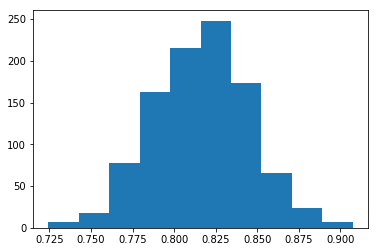

Mean recall: 0.7144018854700069


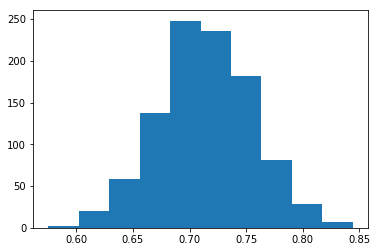

In [36]:
sgds = []
precisions = []
recalls = []
for i in tqdm_notebook(np.arange(1000)):
    X = labeled_sc_pairs[features]
    y = labeled_sc_pairs['same_subtopic_cluster']

    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, test_size=0.5)
    )

    sgd = SGDClassifier(
        loss='log',
        max_iter=100,
        n_jobs=2,
        learning_rate='optimal',
        penalty='l2',
        alpha=0.001,
        l1_ratio=0.15
    )
    sgd.fit(X_train, y_train)

    pred = sgd.predict(X_test)
    
    sgds += [sgd]
    precisions += [metrics.precision_score(y_test, pred)]
    recalls += [metrics.recall_score(y_test, pred)]
    
print('Mean precision: %s' % str(np.mean(precisions)))
plt.hist(precisions)
plt.show()
print('Mean recall: %s' % str(np.mean(recalls)))
plt.hist(recalls)
plt.show()

In [37]:
precisions[-10:]

[0.8055555555555556,
 0.7523364485981309,
 0.7990196078431373,
 0.7688679245283019,
 0.8232323232323232,
 0.7638190954773869,
 0.8472906403940886,
 0.8488372093023255,
 0.837696335078534,
 0.8709677419354839]

In [38]:
recalls[-10:]

[0.6682027649769585,
 0.7123893805309734,
 0.7244444444444444,
 0.7546296296296297,
 0.7244444444444444,
 0.7524752475247525,
 0.7445887445887446,
 0.6320346320346321,
 0.6956521739130435,
 0.675]

In [ ]:
# scc = sgds[1]
# with open('subtopic_cluster_classifier.pkl', 'wb') as output:
#     pickle.dump(scc, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('subtopic_cluster_classifier.pkl', 'rb') as input:
    scc = pickle.load(input)

In [ ]:
labeled_sc_pairs['same_subtopic_cluster_predicted'] = (
    scc.predict(X)
)
labeled_sc_pairs['same_subtopic_cluster_probability'] = (
    scc.predict_proba(X)[:, 1]
)

In [ ]:
for idx, row in labeled_sc_pairs[
    ((labeled_sc_pairs.same_subtopic_cluster == 0)
     & (labeled_sc_pairs.same_subtopic_cluster_predicted == 1))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

In [ ]:
for idx, row in labeled_sc_pairs[
    ((labeled_sc_pairs.same_subtopic_cluster == 1)
     & (labeled_sc_pairs.same_subtopic_cluster_predicted == 0))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

# Supervised topic clustering

## Generate same_subtopic_cluster_probs graph

In [ ]:
def get_same_subtopic_cluster_probs(subset, pairs_dists_max_memory_use_mb=500):
    n_articles = len(subset)
    subset_indices = subset.index.values
    
    same_subtopic_cluster_probs = lil_matrix((n_articles, n_articles))
    num_dist_matrices = 4
    per_dist_matrix_max_memory = pairs_dists_max_memory_use_mb / num_dist_matrices / 2
    cols_batch = int(min(n_articles, per_dist_matrix_max_memory/8e-6))
    rows_batch = int(min(n_articles, per_dist_matrix_max_memory/(cols_batch * 8e-6)))

    # slice first articles
    for start_row in np.arange(0, n_articles, rows_batch):
        end_row = min(start_row+rows_batch, n_articles)

        # get first articles' vectors
        first_article_indices = subset_indices[start_row:end_row]
        first_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[first_article_indices]
        first_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[first_article_indices]
        first_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[first_article_indices]
        first_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[first_article_indices]
        first_titles_dense_matrix = titles_dense_matrix[first_article_indices]
        first_texts_dense_matrix = texts_dense_matrix[first_article_indices] 

        # slice second articles
        for start_col in np.arange(start_row, n_articles, cols_batch):
            end_col = min(start_col+cols_batch, n_articles)

            # get second articles' vectors
            second_article_indices = subset_indices[start_col:end_col]    
            second_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[second_article_indices]
            second_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[second_article_indices]
            second_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[second_article_indices]
            second_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[second_article_indices]
            second_titles_dense_matrix = titles_dense_matrix[second_article_indices]
            second_texts_dense_matrix = texts_dense_matrix[second_article_indices]

            # create article pairs distance matrices
            titles_dists = 1-cosine_similarity(first_titles_tfidf_matrix, second_titles_tfidf_matrix)
            texts_dists = 1-cosine_similarity(first_texts_tfidf_matrix, second_texts_tfidf_matrix)
            nouns_dists = 1-cosine_similarity(first_nouns_tfidf_matrix, second_nouns_tfidf_matrix)
            adjs_dists = 1-cosine_similarity(first_adjs_tfidf_matrix, second_adjs_tfidf_matrix)
            titles_dense_dists = 1-cosine_similarity(first_titles_dense_matrix, second_titles_dense_matrix)
            texts_dense_dists = 1-cosine_similarity(first_texts_dense_matrix, second_texts_dense_matrix)
            
            # conserve memory
            del second_article_indices, second_titles_tfidf_matrix, second_texts_tfidf_matrix,\
                second_nouns_tfidf_matrix, second_adjs_tfidf_matrix, first_titles_dense_matrix,\
                first_texts_dense_matrix, second_titles_dense_matrix, second_texts_dense_matrix
            
            # combine article pairs distances
            pairs_metrics = pd.merge(
                subset[['const', 'n']][start_row:end_row], 
                subset[['const', 'n']][start_col:end_col], 
                on='const'
            )
            pairs_metrics['title_dist'] = titles_dists.reshape(-1)
            pairs_metrics['text_dist'] = texts_dists.reshape(-1)
            pairs_metrics['text_nouns_dist'] = nouns_dists.reshape(-1)
            pairs_metrics['text_adjs_dist'] = adjs_dists.reshape(-1)
            pairs_metrics['title_dense_dist'] = titles_dense_dists.reshape(-1)
            pairs_metrics['text_dense_dist'] = texts_dense_dists.reshape(-1)
            
            # conserve memory
            del titles_dists, texts_dists, nouns_dists, adjs_dists, titles_dense_dists,\
                texts_dense_dists

            # estimate p(same_cluster)
            pairs_metrics['same_subtopic_cluster_probability'] = (
                scc.predict_proba(pairs_metrics[features])[:, 1]
            )
            
            pairs_metrics = pairs_metrics[
                pairs_metrics['same_subtopic_cluster_probability'] > 0
            ]
            
            for x, y, p in zip(pairs_metrics['n_x'],
                               pairs_metrics['n_y'],
                               pairs_metrics['same_subtopic_cluster_probability']):
                same_subtopic_cluster_probs[x, y] = same_subtopic_cluster_probs[y, x] = p
    
    return same_subtopic_cluster_probs

## Cluster same_subtopic_cluster_probs graph

In [ ]:
subset2 = subset[
    subset.topic_cluster_id == topic_cluster_id_counts.index[3]
]

subset2.loc[:, 'const'] = np.zeros(len(subset2))
subset2.loc[:, 'n'] = np.arange(len(subset2))
subset2

In [ ]:
sys.getsizeof(subset2)/1e6

In [ ]:
n_articles = len(subset2)
print(n_articles)

In [ ]:
%%time
X = -get_same_subtopic_cluster_probs(subset2).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

In [ ]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

In [ ]:
ac_result.shape

In [ ]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [ ]:
ac_result_dec = ac_result[::-1] # easier to work with

In [ ]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [ ]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [ ]:
n_clusters

In [ ]:
subset2.loc[:, 'subtopic_cluster_id'] = gen_clusters(ac_result, n_clusters)

In [ ]:
subtopic_cluster_id_counts = subset2['subtopic_cluster_id'].value_counts()

In [ ]:
(np.sum(subtopic_cluster_id_counts.values[subtopic_cluster_id_counts.values >= 10])
 /np.sum(subtopic_cluster_id_counts.values))

In [ ]:
subtopic_cluster_id_counts

In [ ]:
iterations = 0 
for idx, ct in zip(subtopic_cluster_id_counts.index, subtopic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset2[
            subset2['subtopic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')

In [ ]:
sys.getsizeof(recent_content_corpus.df)/1e6

In [ ]:
sys.getsizeof(recent_content_corpus.titles_tfidf_matrix)

In [ ]:
sys.getsizeof(recent_content_corpus.texts_tfidf_matrix)